## Packagek

In [1]:
from google.colab import drive, files
from random import sample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dropout, Flatten, Dense, Input, Embedding, Dot, Reshape, Concatenate, Add, Activation, Lambda
from tensorflow.keras import applications
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

## Adatok előkészítése

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ratings = pd.read_csv('/content/drive/My Drive/MLkurzus/Beadandó/Ratings.csv')
books = pd.read_csv('/content/drive/My Drive/MLkurzus/Beadandó/Books.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
books = books.drop(labels = ['Image-URL-S','Image-URL-M','Image-URL-L'], axis = 1)

In [5]:
rnd = sample(range(0, 1149780), 1149780-150000)
ratings = ratings.drop(labels = rnd, axis = 0)
ratings = ratings.reset_index()

In [6]:
ratings['ISBN2'] = ratings['ISBN'].copy()

In [7]:
le = preprocessing.LabelEncoder()

ratings['ISBN'] = le.fit_transform(ratings['ISBN'])

In [8]:
le = preprocessing.LabelEncoder()

ratings['User-ID'] = le.fit_transform(ratings['User-ID'])

In [9]:
isbn_dict = {}

for i in range(len(ratings['ISBN'])):
  if ratings['ISBN'][i] not in isbn_dict.keys():
    isbn_dict[ratings['ISBN'][i]] = ratings['ISBN2'][i]

In [10]:
ratings

,index,User-ID,ISBN,Book-Rating,ISBN2
0,5,32504,75511,0,2080674722
1,10,32505,26845,0,0425115801
2,14,32505,56522,0,0786013990
3,22,32506,70929,0,1570231028
4,32,32507,21131,0,0380000059
...,...,...,...,...,...
149995,1149730,32500,50189,0,0684838672
149996,1149752,32501,43347,0,0590453653
149997,1149756,32501,43740,0,0590581066
149998,1149758,32502,82671,0,8445072897


## Szétbontás

In [11]:
n_users = ratings['User-ID'].nunique()
n_books = ratings['ISBN'].nunique()

ratings['Book-Rating'] = ratings['Book-Rating'].values.astype(np.float32)
min_rating = min(ratings['Book-Rating'])
max_rating = max(ratings['Book-Rating'])

print(n_users, n_books, min_rating, max_rating)

32745 86448 0.0 10.0


In [12]:
x = ratings[['User-ID', 'ISBN']].values
y = ratings['Book-Rating'].values

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(135000, 2) (15000, 2) (135000,) (15000,)


In [14]:
x_train_array = [x_train[:, 0], x_train[:, 1]]
x_test_array = [x_test[:, 0], x_test[:, 1]]
x_train_array

[array([27158,  7482,  1978, ..., 17346,  4355, 18803]),
 array([45481, 59042, 41322, ..., 40415, 50533, 46305])]

## Másik modell

In [15]:
n_factors = 50

In [16]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [17]:
def RecommenderNet(n_users, n_books, n_factors, min_rating, max_rating):

    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    book = Input(shape=(1,))
    m = EmbeddingLayer(n_books, n_factors)(book)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model2 = Model(inputs=[user, book], outputs=x)
    model2.compile(loss='mean_squared_error', optimizer='Adam')

    return model2

In [18]:
model2 = RecommenderNet(n_users, n_books, n_factors, min_rating, max_rating)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        1637250     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        4322400     ['input_2[0][0]']                
                                                                                              

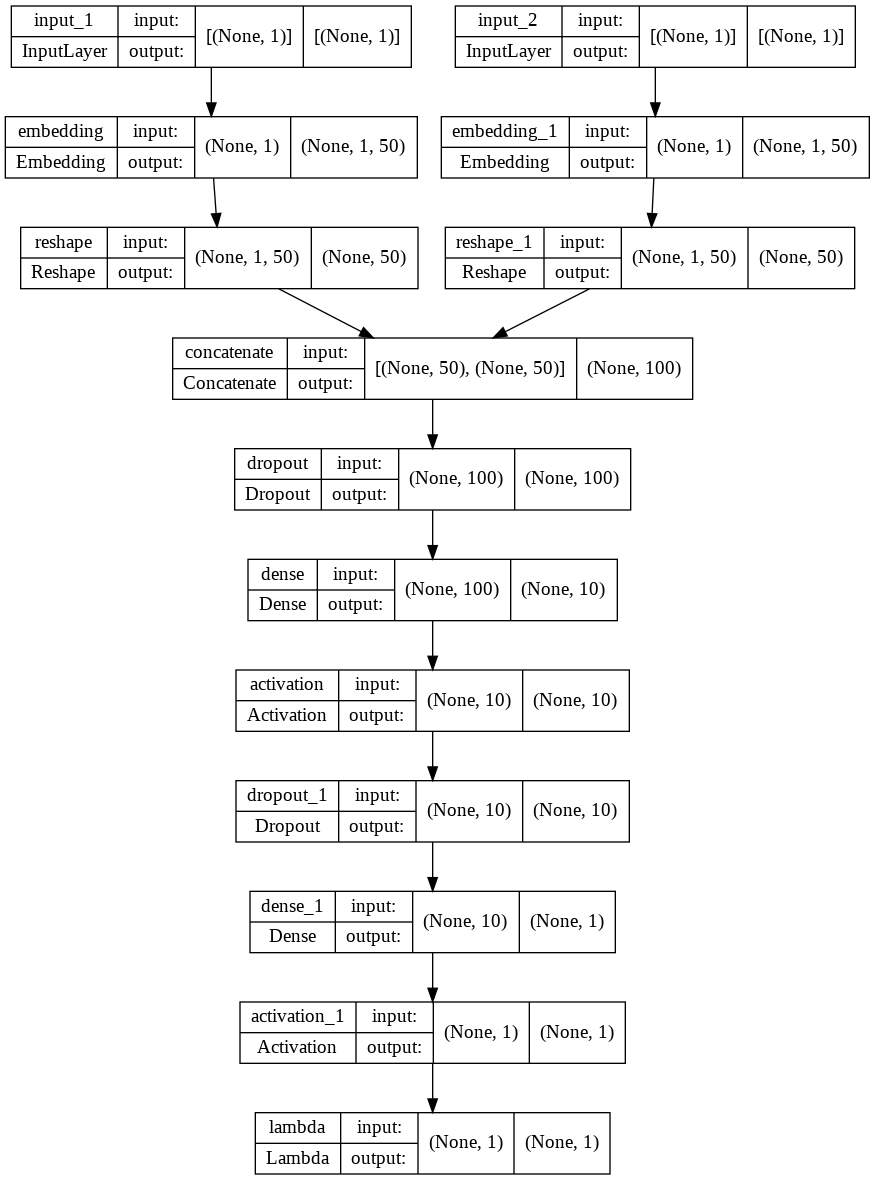

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model2, show_shapes = True)

In [19]:
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)

In [24]:
history2 = model2.fit(x = x_train_array, y = y_train, batch_size = 256, epochs = 150,
                    validation_data=(x_test_array, y_test), callbacks = [early_stopping_callback])

Epoch 1/150
528/528 [==============================] - 6s 6ms/step - loss: 13.4065 - val_loss: 11.9715
Epoch 2/150
528/528 [==============================] - 3s 5ms/step - loss: 8.6284 - val_loss: 13.0549
Epoch 3/150
528/528 [==============================] - 3s 5ms/step - loss: 5.4419 - val_loss: 14.1331
Epoch 4/150
528/528 [==============================] - 3s 5ms/step - loss: 4.2537 - val_loss: 14.8991
Epoch 5/150
528/528 [==============================] - 3s 5ms/step - loss: 3.6714 - val_loss: 15.3637
Epoch 6/150
528/528 [==============================] - 3s 5ms/step - loss: 3.3141 - val_loss: 15.7505


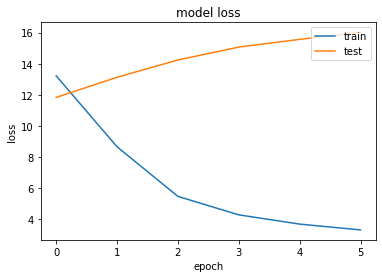

In [ ]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

## Ajánló2

In [28]:
book_data = np.array(list(set(ratings['ISBN'])))
user = np.array([6666 for i in range(len(book_data))])

predictions = model2.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

print(recommended_book_ids)
print(predictions[recommended_book_ids])

[20909 33709 56949 14360 57662]
[5.457717  5.4478636 5.4262733 5.4200163 5.402543 ]


In [29]:
recommended_book_isbn = []

for i in recommended_book_ids:
  recommended_book_isbn.append(isbn_dict.get(i))

recommended_book_isbn

['0375726403', '0451155750', '0786867175', '0345337662', '0802131379']

In [30]:
books[books['ISBN'].isin(recommended_book_isbn)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
479,0375726403,Empire Falls,Richard Russo,2002,Vintage Books USA
925,0451155750,The Dead Zone,Stephen King,2004,Signet Book
2526,0345337662,Interview with the Vampire,Anne Rice,1993,Ballantine Books
23538,0802131379,Last Exit to Brooklyn,Hubert Selby,1988,Grove Press
68954,0786867175,Leap of Faith : Memoirs of an Unexpected Life,Queen Noor,2003,Miramax
